In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
# from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm       import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from kirchhoff import Kirchhoff

# MODEL, GEOM AND SOURCE DEFINITON - for now single sources

In [2]:
# Velocity Model
nx, nz = 101, 101
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Microseismic sources
xmicro = [nx//4, nx//2,  3*(nx//4), ]
zmicro = [nz//4, nz//2,  3*(nz//4), ]
ampmicro = [1,1,1]
ns = len(zmicro)

microseismic = np.zeros((ns, nx, nz))
event_dictionary = []
for ev in range(ns):
    microseismic[ev, xmicro[ev], zmicro[ev]] = ampmicro[ev]
    event_dictionary.append({'event':ev,
                             'sx':xmicro[ev],
                             'sz':zmicro[ev],
                             'amp':ampmicro[ev],
                            })

In [3]:
# Define Receiver grid as lines in X and Z
nr_z = 5
nr_x = 5
rec_string = '%i-by-%i'%(nr_x,nr_z)

rec_buffer = 5 
r_z_locs = np.linspace(rec_buffer*dz, (nz-rec_buffer)*dz, nr_z)
r_x_locs = np.linspace(rec_buffer*dx, (nx-rec_buffer)*dx, nr_x)

rx, rz = np.meshgrid(r_x_locs,r_z_locs)
recs = np.vstack((rx.flatten(), rz.flatten()))
nr = recs.shape[1]
# dr = recs[0,1]-recs[0,0]

Text(0.5, 1.0, 'Acquisition')

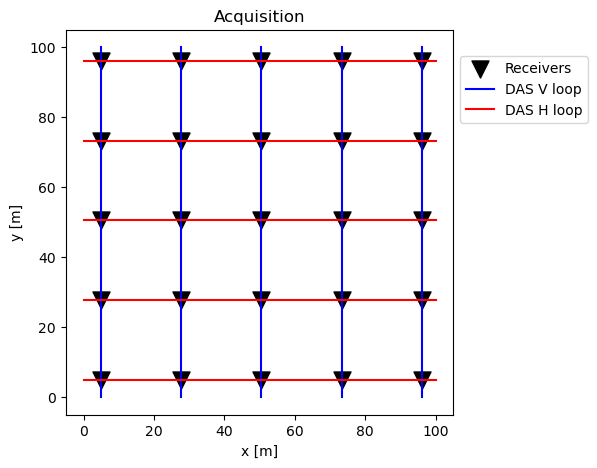

In [4]:
plt.figure(figsize=(5,5))
plt.scatter(recs[0]/dx,  recs[1]/dx, marker='v', s=150, c='k', edgecolors='k', label='Receivers')
for i,r in enumerate(r_x_locs):
    if i ==0: plt.plot([r/dx,r/dx],[0,100], c='b', label='DAS V loop')
    else: plt.plot([r/dx,r/dx],[0,100], c='b')
for i,r in enumerate(r_z_locs):
    if i ==0: plt.plot([0,100], [r/dx,r/dx], c='r', label='DAS H loop')
    else: plt.plot([0,100], [r/dx,r/dx], c='r')
# plt.scatter(x[xmicro]/dx, z[zmicro]/dx, marker='*', s=300, c='yellow', edgecolors='k', label='Sources')
plt.legend(bbox_to_anchor=(1.0, 0.95))
plt.xlim([0,100])
plt.ylim([0,100])
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Acquisition')

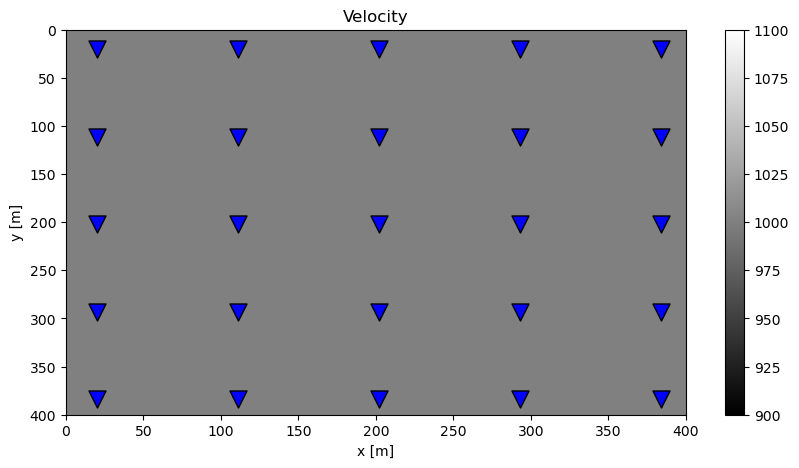

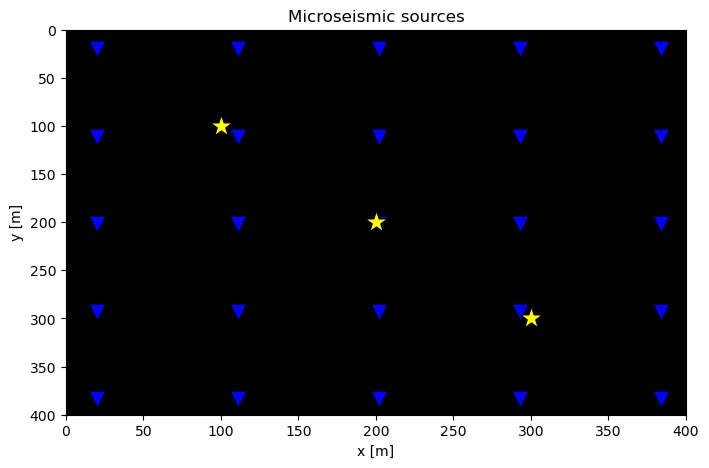

In [5]:
plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(8,5))
im = plt.imshow(microseismic.T, cmap='binary', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(x[xmicro], z[zmicro], marker='*', s=300, c='yellow', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Microseismic sources')
plt.xlim(x[0], x[-1]);

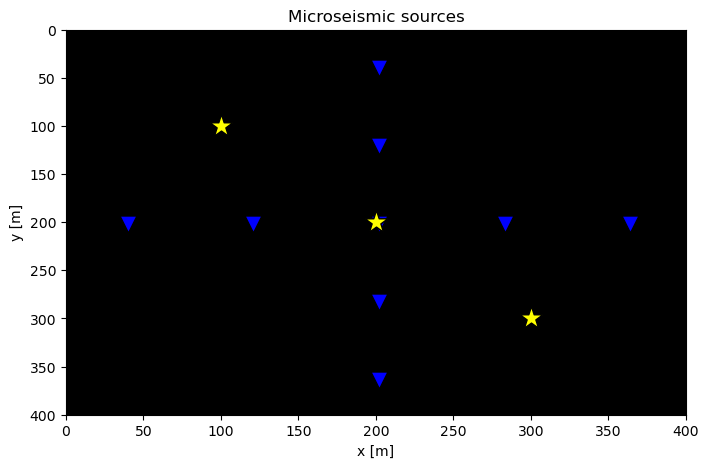

In [6]:
# Cross-Array
rIL_z_locs = np.linspace(10*dz, (nz-10)*dz, nr_z)
rIL_x_locs = np.mean(r_x_locs)
rILx, rILz = np.meshgrid(rIL_x_locs,rIL_z_locs)
recsIL = np.vstack((rILx.flatten(), rILz.flatten()))
nrIL = recsIL.shape[1]

rXL_z_locs = np.mean(r_z_locs)
rXL_x_locs = np.linspace(10*dx, (nx-10)*dx, nr_x)
rXLx, rXLz = np.meshgrid(rXL_x_locs,rXL_z_locs)
recsXL = np.vstack((rXLx.flatten(), rXLz.flatten()))
nrXL = recsXL.shape[1]

recs_X = np.vstack([np.hstack((rILx.flatten(),rXLx.flatten())).flatten(),
                    np.hstack((rILz.flatten(),rXLz.flatten())).flatten(),
                   ])

plt.figure(figsize=(8,5))
im = plt.imshow(microseismic.T, cmap='binary', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs_X[0],  recs_X[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(x[xmicro], z[zmicro], marker='*', s=300, c='yellow', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Microseismic sources')
plt.xlim(x[0], x[-1]);

# MAKE DATA

In [7]:
trav = Kirchhoff._traveltime_table(z, x, recs, recs, v0, mode='analytic')[1] #for modelling

In [8]:
nt = 451
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, nr)
travd = travd.reshape(nx, nz, nr)

In [9]:
# INITIALISE OPERATOR
Op = Kirchhoff(z, x, t, recs[:, :1], recs, v0, wav, wavc, mode='analytic', engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=1169.844846946935 - u^H(Op^Hv)=1169.8448469469354


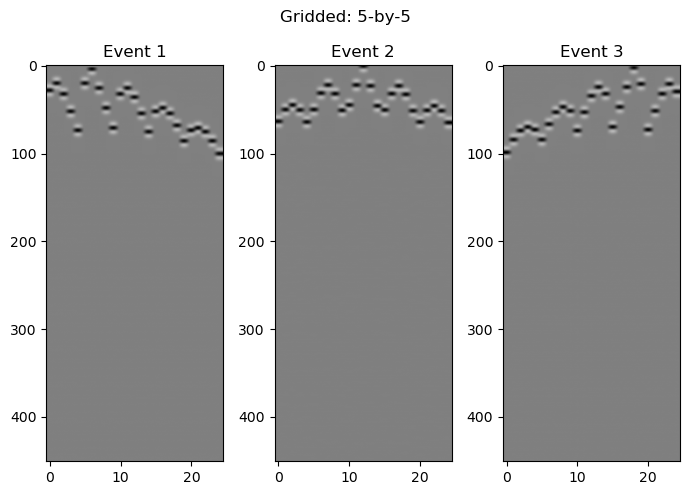

In [10]:
# PERFORM FORWARD (MODEL)
leftEv_fulldata = Op @ microseismic[0].squeeze()
fulldata = Op @ microseismic[1].squeeze()
rightEv_fulldata = Op @ microseismic[2].squeeze()

fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(leftEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(rightEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[0].set_title('Event 1')
axs[1].set_title('Event 2')
axs[2].set_title('Event 3')
plt.suptitle('Gridded: %s'%rec_string)
plt.tight_layout()

In [11]:
# PERFORM ADJOINT (MIGRATE)
mig_Ev1 = Op.H @ leftEv_fulldata
mig_Ev2 = Op.H @ fulldata
mig_Ev3 = Op.H @ rightEv_fulldata

# PERFORM LSQR
minv_Ev1 = lsqr(Op, leftEv_fulldata.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev2 = lsqr(Op, fulldata.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev3 = lsqr(Op, rightEv_fulldata.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 11275 rows and 10201 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   9.377e+00  9.377e+00    1.0e+00  6.3e+00
     1 -3.12026e-04   5.327e+00  5.327e+00    5.7e-01  7.6e-01   7.2e+01  1.0e+00
     2 -2.93921e-04   3.463e+00  3.463e+00    3.7e-01  3.9e-01   1.1e+02  2.3e+00
     3 -1.83242e-04   2.608e+00  2.608e+00    2.8e-01  2.9e-01   1.3e+02  3.6e+00
     4 -1.07864e-05   2.026e+00  2.026e+00    2.2e-01  2.2e-01   1.5e+02  5.2e+00
     5 -2.01958e-04   1.653e+00  1.653e+00    1.8e-01  1.9e-01   1.7e+02  6.9e+00
     6 -3.06996e-04   1.414e+00  1.414e+00    1.5e-01  1.7e-01   1.8e+02  8.7e+00
     7 -6.24752e-04   1.212e+00  1.212e+00    1.3e-01  1.3e-01   2.0e+02  1.1e+01
     8 -8.04267e-04   1.078e+00 

In [12]:
def threeevent_invFigure(mig_list, lsqr_list, event_dictionary, inc_maximums=True, title_string=' '):
    fig, axs = plt.subplots(2,3, figsize=(17, 10))
    
    for i in range(3):
        ev_x = event_dictionary[i]['sx']
        ev_z = event_dictionary[i]['sz']
        
        axs[0][i].imshow(mig_list[i].T, cmap='gray')
        axs[0][i].scatter(ev_x, ev_z, marker='.', s=100, c='g', edgecolors='k')
        axs[0][i].set_title(r'$Event%i : m_{adj}$'%i)
        axs[1][i].imshow(lsqr_list[i].T, cmap='RdBu', 
                         vmin=-1*np.percentile(abs(lsqr_list[i]),99.9), vmax=np.percentile(abs(lsqr_list[i]),99.9))
        axs[1][i].set_title(r'$Event%i : m_{inv}$'%i)
        
        if inc_maximums:
            ev_locs = get_max_locs(lsqr_list[i], n_max=1, rem_edge=False)
            axs[1][i].scatter(ev_locs[0], ev_locs[1], marker='s', s=50, c='yellow', edgecolors='k')
            ev_locs = get_max_locs(lsqr_list[i], n_max=1)
            axs[1][i].scatter(ev_locs[0], ev_locs[1], marker='s', s=50, c='green', edgecolors='k')
    for ax in axs.ravel(): ax.axis('tight')
        
    plt.suptitle(title_string, fontsize=18)
    plt.tight_layout()


In [13]:
def get_max_locs(image, n_max=50, rem_edge=True):
    if rem_edge:
        cropped_image = image[10:-10,10:-10]
        ev_locs = np.array(np.unravel_index(np.argpartition(cropped_image.ravel(), -1*n_max)[-n_max:],
                                     cropped_image.shape))
        return ev_locs+10
        
    else:        
        return np.array(np.unravel_index(np.argpartition(image.ravel(), -1*n_max)[-n_max:],
                                     image.shape))

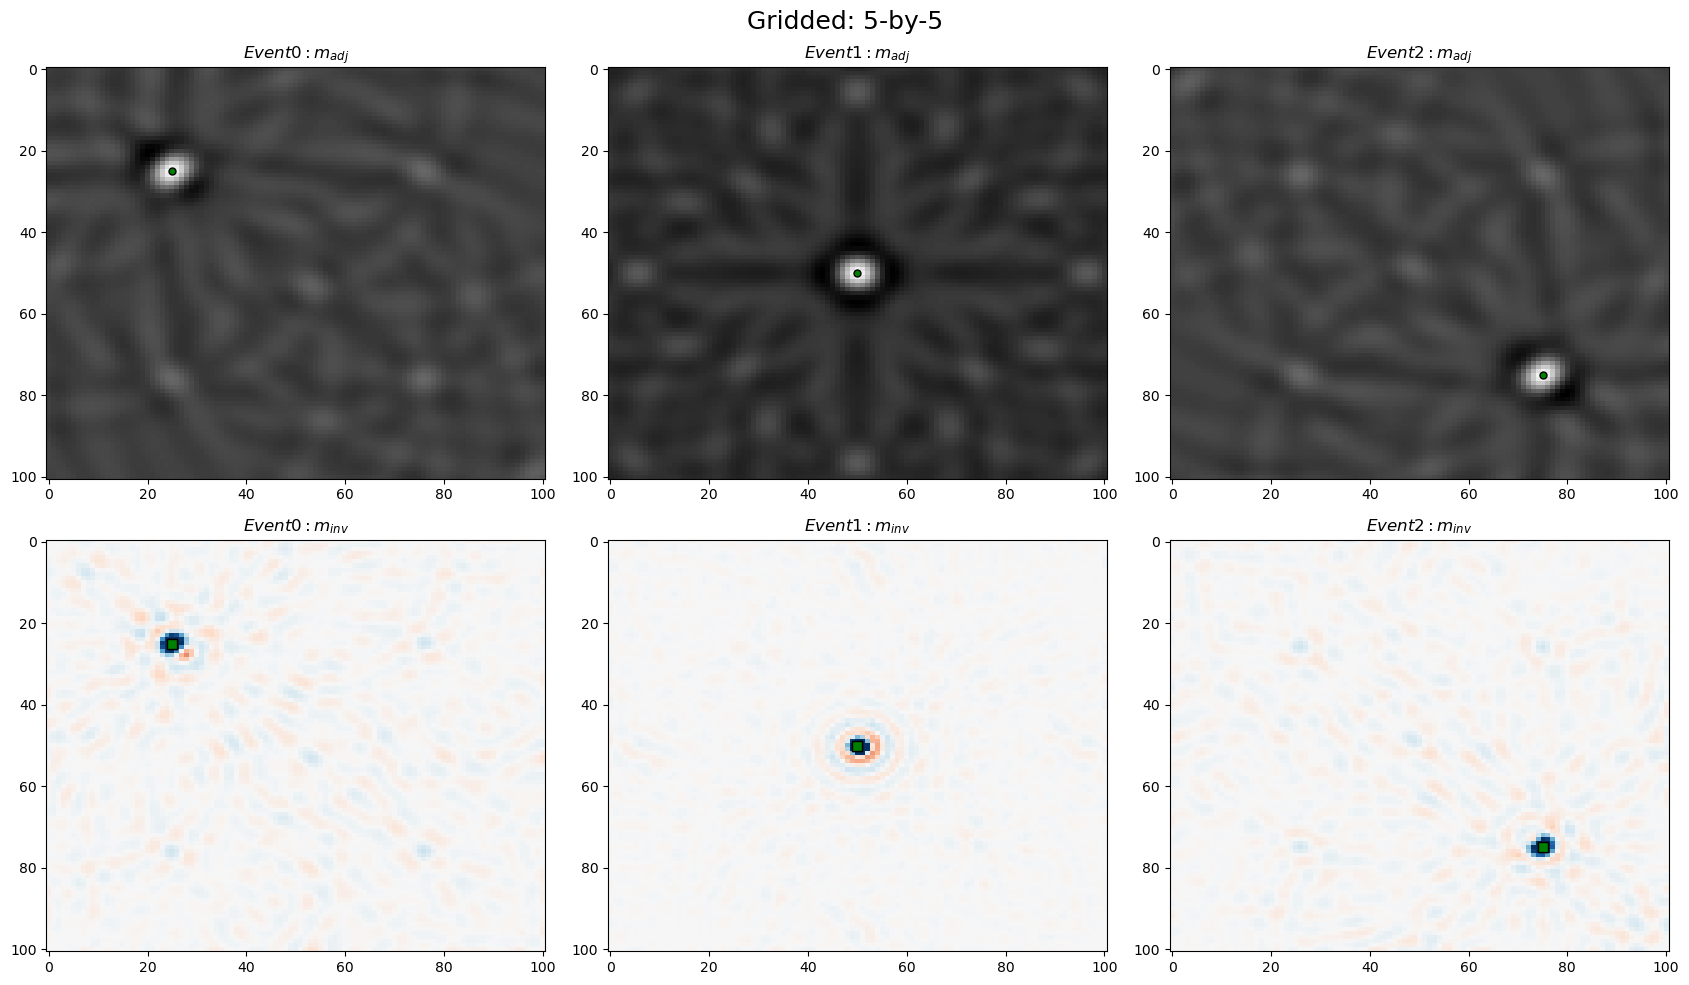

In [14]:
threeevent_invFigure([mig_Ev1, mig_Ev2, mig_Ev3, ],
                     [minv_Ev1, minv_Ev2, minv_Ev3, ],
                     event_dictionary,
                     title_string='Gridded: %s'%rec_string,
                    )

# ALL RECEIVERS BUT WITH DATA AVERAGED

In [15]:
def eventgrid_to_lines(eventdata, rx):
    num_ilines = len(rx)
    num_xlines = len(rx[0])

    micro_data_ILXL = eventdata.reshape([num_ilines,
                                         int(eventdata.shape[0]/num_ilines), 
                                         eventdata.shape[1]])
    micro_data_XL = np.sum(micro_data_ILXL,axis=0)
    micro_data_IL = np.sum(micro_data_ILXL,axis=1)

    vline_data = np.tile(micro_data_XL.T, num_ilines).T
    hline_data = np.repeat(micro_data_IL.T, num_xlines, axis=1).T

    lines_data = np.vstack([hline_data,vline_data])
    return lines_data

In [16]:
leftEv_lines_data = eventgrid_to_lines(leftEv_fulldata, rx) 
lines_data = eventgrid_to_lines(fulldata, rx) 
rightEv_lines_data = eventgrid_to_lines(rightEv_fulldata, rx) 

lines_recs = np.tile(recs,2)

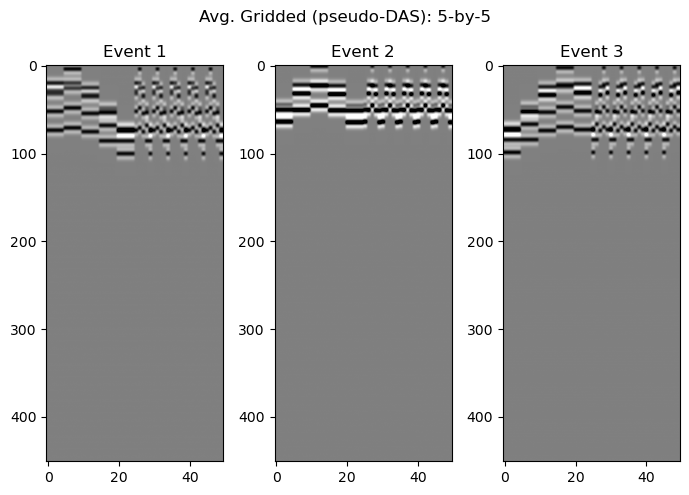

In [17]:
fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(leftEv_lines_data.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(lines_data.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(rightEv_lines_data.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[0].set_title('Event 1')
axs[1].set_title('Event 2')
axs[2].set_title('Event 3')
plt.suptitle('Avg. Gridded (pseudo-DAS): %s'%rec_string)
plt.tight_layout()

In [18]:
Op_lines = Kirchhoff(z, x, t, lines_recs[:, :1], lines_recs, v0, wav, wavc, mode='analytic', engine='numba')

In [19]:
# PERFORM ADJOINT (MIGRATE)
mig_Ev1 = Op_lines.H @ leftEv_lines_data
mig_Ev2 = Op_lines.H @ lines_data
mig_Ev3 = Op_lines.H @ rightEv_lines_data

# PERFORM LSQR
minv_Ev1 = lsqr(Op_lines, leftEv_lines_data.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev2 = lsqr(Op_lines, lines_data.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev3 = lsqr(Op_lines, rightEv_lines_data.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 22550 rows and 10201 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.740e+01  2.740e+01    1.0e+00  2.2e+00
     1  5.48811e-04   2.118e+01  2.118e+01    7.7e-01  3.8e-01   9.6e+01  1.0e+00
     2  5.59454e-04   1.944e+01  1.944e+01    7.1e-01  1.4e-01   1.4e+02  2.2e+00
     3  1.46573e-04   1.884e+01  1.884e+01    6.9e-01  9.2e-02   1.7e+02  3.6e+00
     4 -8.60084e-05   1.853e+01  1.853e+01    6.8e-01  7.0e-02   2.0e+02  5.2e+00
     5 -9.22884e-04   1.830e+01  1.830e+01    6.7e-01  4.5e-02   2.3e+02  7.2e+00
     6 -1.75405e-03   1.813e+01  1.813e+01    6.6e-01  3.4e-02   2.5e+02  9.4e+00
     7 -2.49123e-03   1.804e+01  1.804e+01    6.6e-01  2.5e-02   2.7e+02  1.1e+01
     8 -2.85832e-03   1.795e+01 

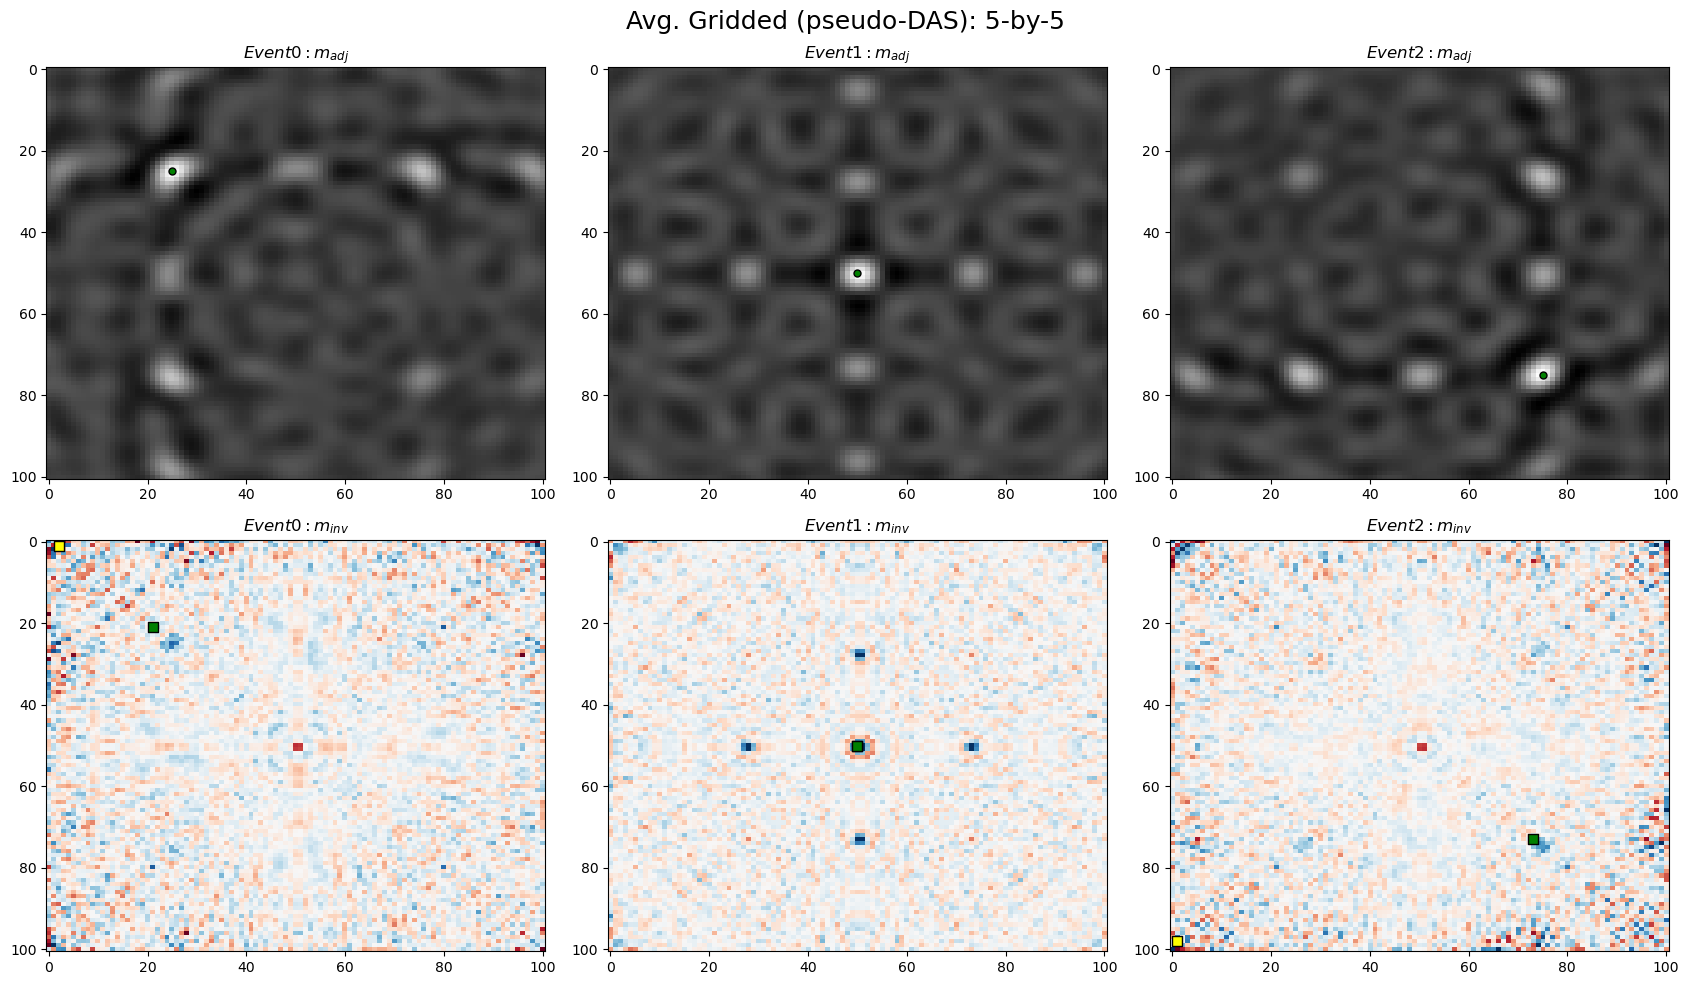

In [20]:
threeevent_invFigure([mig_Ev1, mig_Ev2, mig_Ev3, ],
                     [minv_Ev1, minv_Ev2, minv_Ev3, ],
                     event_dictionary,
                     title_string='Avg. Gridded (pseudo-DAS): %s'%rec_string,)

## KIRCHOFF MODELLING WITH AVERAGING

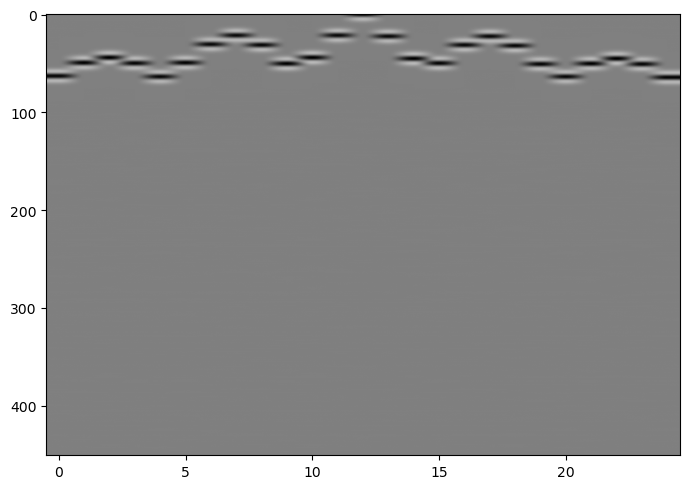

In [21]:
# INITIALISE OPERATOR
Op = Kirchhoff(z, x, t, recs[:, :1], recs, v0, wav, wavc, mode='analytic', engine='numba')

# check operator with dottest
fulldata = Op @ microseismic[1].squeeze()

fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.imshow(fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
plt.tight_layout()

In [22]:
Szop = Sum((nr_z, nr_x, nt), axis=0)
Sxop = Sum((nr_z, nr_x, nt), axis=1)

zavdata = Szop.H @ Szop @ fulldata.reshape(nr_z, nr_x, nt)
xavdata = Sxop.H @ Sxop @ fulldata.reshape(nr_z, nr_x, nt)

Vop = VStack([Sxop.H @ Sxop, Szop.H @ Szop])

LinesOp = Vop * Op


lines_data_op_Ev1 = LinesOp @ microseismic[0].squeeze()
lines_data_op_Ev2 = LinesOp @ microseismic[1].squeeze()
lines_data_op_Ev3 = LinesOp @ microseismic[2].squeeze()

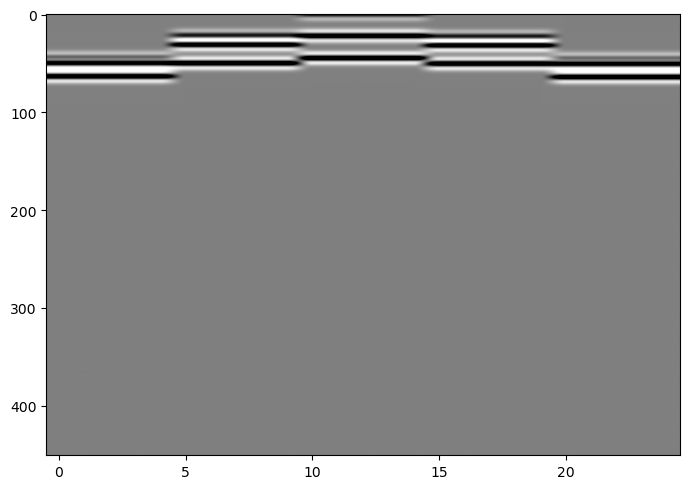

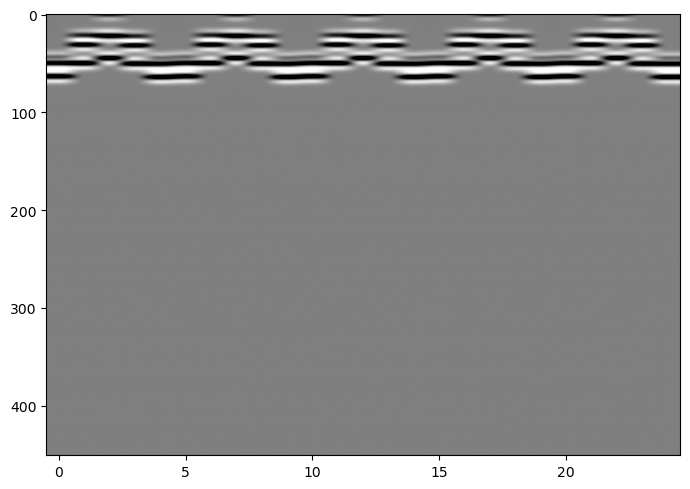

In [23]:
fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.imshow(lines_data[:nr_x*nr_z].T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
plt.tight_layout()

fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.imshow(lines_data[nr_x*nr_z:].T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
plt.tight_layout()

NameError: name 'lines_data_op' is not defined

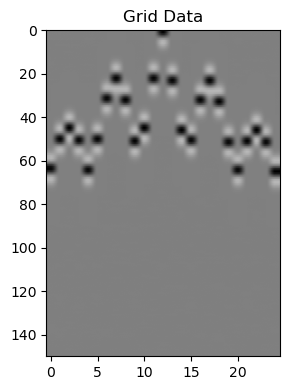

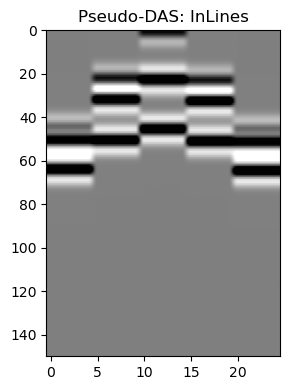

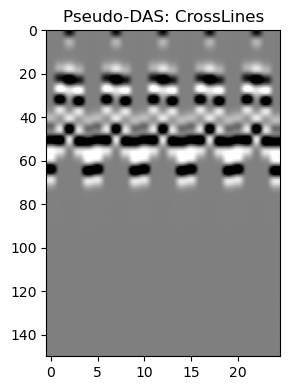

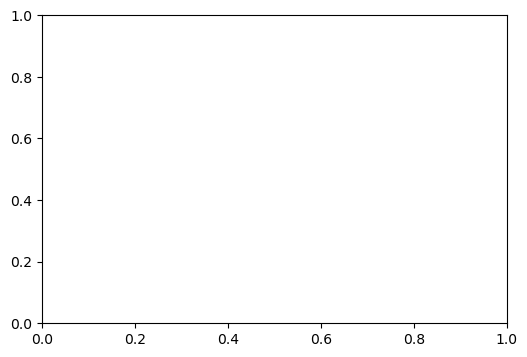

In [24]:
fig,ax=plt.subplots(1,1,figsize=(3,4))
ax.imshow(fulldata.reshape(nr_z*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
ax.set_ylim([150,0])
plt.title('Grid Data')
plt.tight_layout()


fig,ax=plt.subplots(1,1,figsize=(3,4))
ax.imshow(xavdata.reshape(nr_z*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
ax.set_ylim([150,0])
plt.title('Pseudo-DAS: InLines')
plt.tight_layout()

fig,ax=plt.subplots(1,1,figsize=(3,4))
ax.imshow(zavdata.reshape(nr_z*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
ax.set_ylim([150,0])
plt.title('Pseudo-DAS: CrossLines')
plt.tight_layout()

fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.imshow(lines_data_op.reshape(nr_z*nr_x*2,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
ax.set_ylim([150,0])
plt.title('Pseudo-DAS: Full Data')
plt.tight_layout()

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.imshow(lines_data_op.reshape(nr_z*nr_x*2,nt)[:nr_z*nr_x].T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
plt.tight_layout()

fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.imshow(lines_data_op.reshape(nr_z*nr_x*2,nt)[nr_z*nr_x:].T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
plt.tight_layout()

In [ ]:
# PERFORM ADJOINT (MIGRATE)
mig_Ev1 = (Op_lines.H @ lines_data_op_Ev1).reshape(nx, nz)
mig_Ev2 = (Op_lines.H @ lines_data_op_Ev2).reshape(nx, nz)
mig_Ev3 = (Op_lines.H @ lines_data_op_Ev3).reshape(nx, nz)

# PERFORM LSQR
minv_Ev1 = lsqr(LinesOp, lines_data_op_Ev1.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev2 = lsqr(LinesOp, lines_data_op_Ev2.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)
minv_Ev3 = lsqr(LinesOp, lines_data_op_Ev3.ravel(), iter_lim=100, show=True)[0].reshape(nx, nz)

In [ ]:
minv_Ev2.shape, mig_Ev2.shape

In [ ]:
threeevent_invFigure([mig_Ev1, mig_Ev2, mig_Ev3, ],
                     [minv_Ev1, minv_Ev2, minv_Ev3, ],
                     event_dictionary,
                     title_string='Intelligent Inversion (Pseudo-DAS): %s'%rec_string,)